### 5.5) Gathering Input Graphs

In [74]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [75]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-productivity-rate-graphs/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

In [76]:
graphs

[Data(x=[560, 560], edge_index=[2, 440258], edge_attr=[440258, 4], y=[1]),
 Data(x=[603, 603], edge_index=[2, 319768], edge_attr=[319768, 4], y=[1]),
 Data(x=[525, 525], edge_index=[2, 92854], edge_attr=[92854, 4], y=[1]),
 Data(x=[648, 648], edge_index=[2, 477458], edge_attr=[477458, 4], y=[1]),
 Data(x=[484, 484], edge_index=[2, 327346], edge_attr=[327346, 4], y=[1]),
 Data(x=[430, 430], edge_index=[2, 295144], edge_attr=[295144, 4], y=[1]),
 Data(x=[716, 716], edge_index=[2, 348140], edge_attr=[348140, 4], y=[1]),
 Data(x=[706, 706], edge_index=[2, 401906], edge_attr=[401906, 4], y=[1]),
 Data(x=[577, 577], edge_index=[2, 488282], edge_attr=[488282, 4], y=[1]),
 Data(x=[599, 599], edge_index=[2, 582338], edge_attr=[582338, 4], y=[1]),
 Data(x=[451, 451], edge_index=[2, 274074], edge_attr=[274074, 4], y=[1]),
 Data(x=[426, 426], edge_index=[2, 277242], edge_attr=[277242, 4], y=[1]),
 Data(x=[591, 591], edge_index=[2, 571268], edge_attr=[571268, 4], y=[1]),
 Data(x=[199, 199], edge_in

In [77]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [78]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 6) Create GAT Model for Graph Regression¶

GAT model takes graph as input, applies GAT layers to learn node embeddings, aggregates (mean pooling or attention pooling) to a graph level embedding, and passes that to fully connected layers to predict a single value (productivity)

global mean pooling

In [79]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion, device):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load best model and evaluate on validation set
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion, device)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")


Fold 1
Epoch 0 | Train Loss: 7727.4494 | Val Loss: 7254.0736 | RMSE: 85.1709 | MAE: 84.9299
Epoch 1 | Train Loss: 7630.0686 | Val Loss: 7072.4078 | RMSE: 84.0976 | MAE: 83.8529
Epoch 2 | Train Loss: 7328.1284 | Val Loss: 6659.9277 | RMSE: 81.6084 | MAE: 81.3547
Epoch 3 | Train Loss: 6791.1771 | Val Loss: 6015.5741 | RMSE: 77.5601 | MAE: 77.2909
Epoch 4 | Train Loss: 6000.8353 | Val Loss: 5133.7450 | RMSE: 71.6502 | MAE: 71.3544
Epoch 5 | Train Loss: 4979.5679 | Val Loss: 4001.8425 | RMSE: 63.2601 | MAE: 62.9186
Epoch 6 | Train Loss: 3710.6447 | Val Loss: 2689.6239 | RMSE: 51.8616 | MAE: 51.4339
Epoch 7 | Train Loss: 2306.7858 | Val Loss: 1382.9986 | RMSE: 37.1887 | MAE: 36.5686
Epoch 8 | Train Loss: 1042.7489 | Val Loss: 380.0384 | RMSE: 19.4946 | MAE: 18.2330
Epoch 9 | Train Loss: 239.9035 | Val Loss: 50.8530 | RMSE: 7.1311 | MAE: 6.5091
Epoch 10 | Train Loss: 89.5570 | Val Loss: 99.5035 | RMSE: 9.9751 | MAE: 8.4115
Epoch 11 | Train Loss: 102.1922 | Val Loss: 91.9184 | RMSE: 9.5874 | 

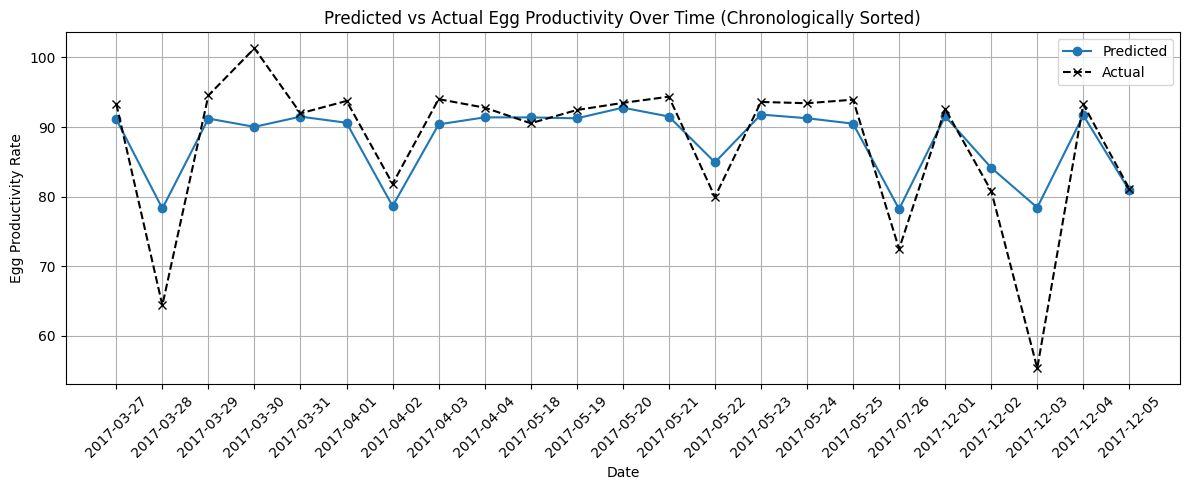

In [80]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

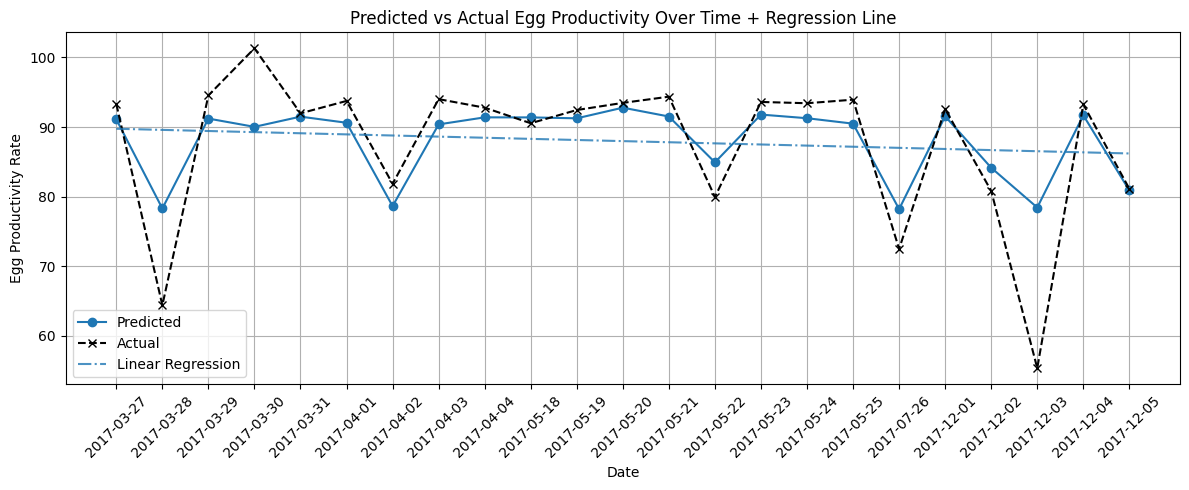

In [81]:
from sklearn.linear_model import LinearRegression

n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date").reset_index(drop=True)

X = np.arange(len(df_plot)).reshape(-1, 1)  # index as time proxy
y = df_plot["predicted"].values
reg = LinearRegression().fit(X, y)
reg_line = reg.predict(X)

# Add regression line to the plot
plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.plot(df_plot["date"], reg_line, label="Linear Regression", linestyle="-.", color="tab:blue", alpha=0.8)

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time + Regression Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


15:41:39 - cmdstanpy - INFO - Chain [1] start processing
15:41:39 - cmdstanpy - INFO - Chain [1] done processing


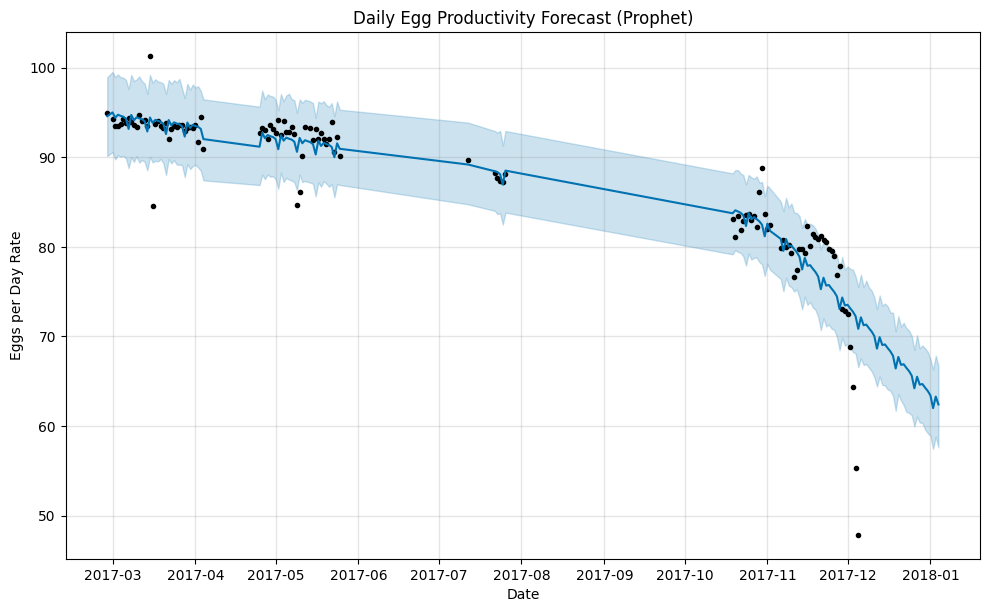

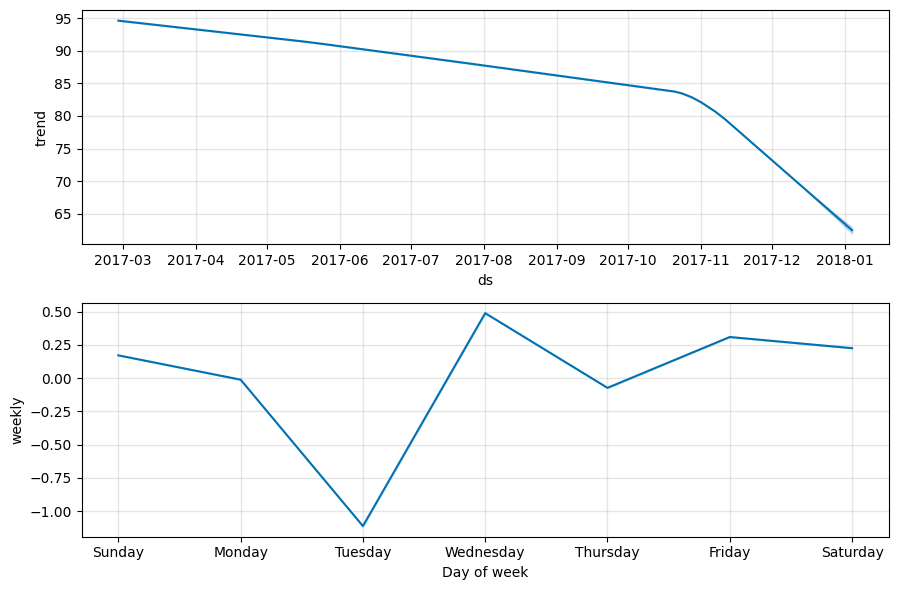

In [83]:
from prophet import Prophet

eggs_per_day_df['ds'] = pd.to_datetime(eggs_per_day_df['date'])
eggs_per_day_df['y'] = eggs_per_day_df['productivity rate']
ts = eggs_per_day_df[['ds','y']].sort_values('ds').reset_index(drop=True)

# 2. Fit Prophet on the real series
m = Prophet(daily_seasonality=False, weekly_seasonality=True)
m.fit(ts)

# 3. Make a future DataFrame (e.g. next 30 days)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# 4. Plot the forecast
fig1 = m.plot(forecast)
plt.title("Daily Egg Productivity Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Eggs per Day Rate")
plt.show()

# 5. (Optional) View trend & weekly seasonality
fig2 = m.plot_components(forecast)
plt.show()

global_max_pool instead of global_mean_pool

In [84]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = global_max_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_max_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_max_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1132 | Val Loss: 0.6122 | RMSE: 0.7824 | MAE: 0.7223


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.1049 | Val Loss: 0.6144 | RMSE: 0.7838 | MAE: 0.7223


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0960 | Val Loss: 0.6151 | RMSE: 0.7843 | MAE: 0.7217


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0864 | Val Loss: 0.6155 | RMSE: 0.7846 | MAE: 0.7203


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0726 | Val Loss: 0.6148 | RMSE: 0.7841 | MAE: 0.7172


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0533 | Val Loss: 0.6021 | RMSE: 0.7759 | MAE: 0.7089


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0187 | Val Loss: 0.5893 | RMSE: 0.7677 | MAE: 0.6960


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9701 | Val Loss: 0.5304 | RMSE: 0.7283 | MAE: 0.6620


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.8938 | Val Loss: 0.4500 | RMSE: 0.6709 | MAE: 0.6054


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.7615 | Val Loss: 0.3240 | RMSE: 0.5692 | MAE: 0.5082


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.6236 | Val Loss: 0.2332 | RMSE: 0.4829 | MAE: 0.4050


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.4872 | Val Loss: 0.1609 | RMSE: 0.4012 | MAE: 0.3366


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.4315 | Val Loss: 0.1446 | RMSE: 0.3803 | MAE: 0.3077


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.3923 | Val Loss: 0.1388 | RMSE: 0.3725 | MAE: 0.2930


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.3678 | Val Loss: 0.1301 | RMSE: 0.3607 | MAE: 0.2877


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.3652 | Val Loss: 0.1324 | RMSE: 0.3639 | MAE: 0.2878


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.3431 | Val Loss: 0.1439 | RMSE: 0.3793 | MAE: 0.3173


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.3258 | Val Loss: 0.1404 | RMSE: 0.3747 | MAE: 0.3025


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.3251 | Val Loss: 0.1335 | RMSE: 0.3654 | MAE: 0.2999


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.3115 | Val Loss: 0.1514 | RMSE: 0.3891 | MAE: 0.3264


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.3030 | Val Loss: 0.1383 | RMSE: 0.3719 | MAE: 0.3039


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.2944 | Val Loss: 0.1433 | RMSE: 0.3785 | MAE: 0.3100


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.2811 | Val Loss: 0.1496 | RMSE: 0.3868 | MAE: 0.3230


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.2797 | Val Loss: 0.1476 | RMSE: 0.3842 | MAE: 0.3172


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2804 | Val Loss: 0.1494 | RMSE: 0.3865 | MAE: 0.3175
Early stopping triggered.
Fold 1 final RMSE: 0.3607, MAE: 0.2877
Fold 2


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1395 | Val Loss: 0.4621 | RMSE: 0.6798 | MAE: 0.6414


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.1332 | Val Loss: 0.4637 | RMSE: 0.6809 | MAE: 0.6429


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.1262 | Val Loss: 0.4614 | RMSE: 0.6793 | MAE: 0.6413


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.1164 | Val Loss: 0.4574 | RMSE: 0.6763 | MAE: 0.6385


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0980 | Val Loss: 0.4319 | RMSE: 0.6572 | MAE: 0.6187


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0640 | Val Loss: 0.4030 | RMSE: 0.6348 | MAE: 0.5957


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0133 | Val Loss: 0.3522 | RMSE: 0.5935 | MAE: 0.5517


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9293 | Val Loss: 0.2515 | RMSE: 0.5015 | MAE: 0.4494


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.8281 | Val Loss: 0.2057 | RMSE: 0.4535 | MAE: 0.4103


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.7223 | Val Loss: 0.1682 | RMSE: 0.4101 | MAE: 0.3562


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.6064 | Val Loss: 0.1707 | RMSE: 0.4132 | MAE: 0.3396


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.5103 | Val Loss: 0.1710 | RMSE: 0.4135 | MAE: 0.2984


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.4544 | Val Loss: 0.1741 | RMSE: 0.4173 | MAE: 0.2907


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.3852 | Val Loss: 0.2630 | RMSE: 0.5129 | MAE: 0.4183


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.3891 | Val Loss: 0.2074 | RMSE: 0.4554 | MAE: 0.3303


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.3768 | Val Loss: 0.2287 | RMSE: 0.4783 | MAE: 0.3536


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.3485 | Val Loss: 0.2379 | RMSE: 0.4877 | MAE: 0.3614


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.3232 | Val Loss: 0.1995 | RMSE: 0.4467 | MAE: 0.3200


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.3278 | Val Loss: 0.3124 | RMSE: 0.5589 | MAE: 0.4413


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.3127 | Val Loss: 0.2337 | RMSE: 0.4834 | MAE: 0.3599
Early stopping triggered.
Fold 2 final RMSE: 0.4101, MAE: 0.3562
Fold 3


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.8348 | Val Loss: 1.6877 | RMSE: 1.2991 | MAE: 0.9449


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.8264 | Val Loss: 1.6888 | RMSE: 1.2995 | MAE: 0.9418


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.8167 | Val Loss: 1.6879 | RMSE: 1.2992 | MAE: 0.9383


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.8050 | Val Loss: 1.6819 | RMSE: 1.2969 | MAE: 0.9333


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.7898 | Val Loss: 1.6747 | RMSE: 1.2941 | MAE: 0.9249


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.7679 | Val Loss: 1.6517 | RMSE: 1.2852 | MAE: 0.9104


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.7329 | Val Loss: 1.5994 | RMSE: 1.2647 | MAE: 0.8870


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.6710 | Val Loss: 1.5297 | RMSE: 1.2368 | MAE: 0.8418


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.5883 | Val Loss: 1.4112 | RMSE: 1.1879 | MAE: 0.7744


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.4972 | Val Loss: 1.2922 | RMSE: 1.1368 | MAE: 0.6927


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.4205 | Val Loss: 1.2165 | RMSE: 1.1029 | MAE: 0.6225


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.3695 | Val Loss: 1.1282 | RMSE: 1.0622 | MAE: 0.5833


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.3153 | Val Loss: 1.0453 | RMSE: 1.0224 | MAE: 0.5403


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.2708 | Val Loss: 0.9592 | RMSE: 0.9794 | MAE: 0.5381


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.2578 | Val Loss: 0.9147 | RMSE: 0.9564 | MAE: 0.5285


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.2346 | Val Loss: 0.8846 | RMSE: 0.9405 | MAE: 0.5054


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.2132 | Val Loss: 0.8597 | RMSE: 0.9272 | MAE: 0.5003


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.2043 | Val Loss: 0.8435 | RMSE: 0.9184 | MAE: 0.4945


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2035 | Val Loss: 0.8377 | RMSE: 0.9153 | MAE: 0.4898


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.1949 | Val Loss: 0.8093 | RMSE: 0.8996 | MAE: 0.4897


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.1894 | Val Loss: 0.8132 | RMSE: 0.9018 | MAE: 0.4824


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.1779 | Val Loss: 0.7908 | RMSE: 0.8893 | MAE: 0.4849


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.1962 | Val Loss: 0.7669 | RMSE: 0.8758 | MAE: 0.4938


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.1820 | Val Loss: 0.8194 | RMSE: 0.9052 | MAE: 0.4777


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.1669 | Val Loss: 0.7772 | RMSE: 0.8816 | MAE: 0.4774


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.1552 | Val Loss: 0.7581 | RMSE: 0.8707 | MAE: 0.4818


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.1507 | Val Loss: 0.7651 | RMSE: 0.8747 | MAE: 0.4760


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1435 | Val Loss: 0.7703 | RMSE: 0.8777 | MAE: 0.4723


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1489 | Val Loss: 0.7462 | RMSE: 0.8638 | MAE: 0.4733


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1408 | Val Loss: 0.7683 | RMSE: 0.8765 | MAE: 0.4668


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1250 | Val Loss: 0.7383 | RMSE: 0.8592 | MAE: 0.4719


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1368 | Val Loss: 0.7437 | RMSE: 0.8624 | MAE: 0.4698


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1218 | Val Loss: 0.7223 | RMSE: 0.8499 | MAE: 0.4743


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1340 | Val Loss: 0.7486 | RMSE: 0.8652 | MAE: 0.4640


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1149 | Val Loss: 0.7080 | RMSE: 0.8414 | MAE: 0.4819


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.1240 | Val Loss: 0.7045 | RMSE: 0.8394 | MAE: 0.4835


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.1169 | Val Loss: 0.7337 | RMSE: 0.8565 | MAE: 0.4649


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.1348 | Val Loss: 0.7069 | RMSE: 0.8408 | MAE: 0.4768


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.1077 | Val Loss: 0.7198 | RMSE: 0.8484 | MAE: 0.4620


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.1082 | Val Loss: 0.7273 | RMSE: 0.8528 | MAE: 0.4602


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.0999 | Val Loss: 0.7004 | RMSE: 0.8369 | MAE: 0.4676


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.1042 | Val Loss: 0.7211 | RMSE: 0.8492 | MAE: 0.4587


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 42 | Train Loss: 0.1221 | Val Loss: 0.6838 | RMSE: 0.8269 | MAE: 0.4831


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 43 | Train Loss: 0.1023 | Val Loss: 0.7301 | RMSE: 0.8545 | MAE: 0.4621


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 44 | Train Loss: 0.0828 | Val Loss: 0.7229 | RMSE: 0.8502 | MAE: 0.4568


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 45 | Train Loss: 0.0929 | Val Loss: 0.7199 | RMSE: 0.8485 | MAE: 0.4518


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 46 | Train Loss: 0.1166 | Val Loss: 0.6980 | RMSE: 0.8354 | MAE: 0.4536


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 47 | Train Loss: 0.0878 | Val Loss: 0.6866 | RMSE: 0.8286 | MAE: 0.4577


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 48 | Train Loss: 0.0850 | Val Loss: 0.6902 | RMSE: 0.8308 | MAE: 0.4529


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 49 | Train Loss: 0.0872 | Val Loss: 0.6968 | RMSE: 0.8347 | MAE: 0.4493


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 50 | Train Loss: 0.0781 | Val Loss: 0.6685 | RMSE: 0.8176 | MAE: 0.4683


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 51 | Train Loss: 0.0564 | Val Loss: 0.6867 | RMSE: 0.8287 | MAE: 0.4474


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 52 | Train Loss: 0.1001 | Val Loss: 0.7119 | RMSE: 0.8438 | MAE: 0.4458


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 53 | Train Loss: 0.0624 | Val Loss: 0.6734 | RMSE: 0.8206 | MAE: 0.4533


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 54 | Train Loss: 0.0677 | Val Loss: 0.6978 | RMSE: 0.8353 | MAE: 0.4431


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 55 | Train Loss: 0.0657 | Val Loss: 0.6602 | RMSE: 0.8125 | MAE: 0.4571


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 56 | Train Loss: 0.0537 | Val Loss: 0.6842 | RMSE: 0.8271 | MAE: 0.4412


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 57 | Train Loss: 0.0478 | Val Loss: 0.6616 | RMSE: 0.8134 | MAE: 0.4498


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 58 | Train Loss: 0.0439 | Val Loss: 0.6832 | RMSE: 0.8266 | MAE: 0.4394


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 59 | Train Loss: 0.0487 | Val Loss: 0.6518 | RMSE: 0.8073 | MAE: 0.4630


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 60 | Train Loss: 0.0503 | Val Loss: 0.6509 | RMSE: 0.8068 | MAE: 0.4705


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 61 | Train Loss: 0.0413 | Val Loss: 0.6847 | RMSE: 0.8275 | MAE: 0.4376


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 62 | Train Loss: 0.0589 | Val Loss: 0.6767 | RMSE: 0.8226 | MAE: 0.4419


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 63 | Train Loss: 0.0970 | Val Loss: 0.6984 | RMSE: 0.8357 | MAE: 0.4457


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 64 | Train Loss: 0.0248 | Val Loss: 0.6999 | RMSE: 0.8366 | MAE: 0.4331


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 65 | Train Loss: 0.0836 | Val Loss: 0.6581 | RMSE: 0.8112 | MAE: 0.4582


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 66 | Train Loss: 0.0474 | Val Loss: 0.6851 | RMSE: 0.8277 | MAE: 0.4366


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 67 | Train Loss: 0.0796 | Val Loss: 0.6684 | RMSE: 0.8176 | MAE: 0.4451


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 68 | Train Loss: 0.0389 | Val Loss: 0.6779 | RMSE: 0.8233 | MAE: 0.4393


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 69 | Train Loss: 0.0586 | Val Loss: 0.6542 | RMSE: 0.8088 | MAE: 0.4669


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 70 | Train Loss: 0.0233 | Val Loss: 0.6925 | RMSE: 0.8321 | MAE: 0.4332
Early stopping triggered.
Fold 3 final RMSE: 0.8068, MAE: 0.4705
Fold 4


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1083 | Val Loss: 0.5520 | RMSE: 0.7430 | MAE: 0.6688


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.1040 | Val Loss: 0.5484 | RMSE: 0.7405 | MAE: 0.6667


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0991 | Val Loss: 0.5432 | RMSE: 0.7370 | MAE: 0.6635


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0910 | Val Loss: 0.5340 | RMSE: 0.7307 | MAE: 0.6578


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0763 | Val Loss: 0.5181 | RMSE: 0.7198 | MAE: 0.6477


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0462 | Val Loss: 0.4862 | RMSE: 0.6973 | MAE: 0.6264


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.9921 | Val Loss: 0.4313 | RMSE: 0.6568 | MAE: 0.5866


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.8978 | Val Loss: 0.3488 | RMSE: 0.5906 | MAE: 0.5181


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.7719 | Val Loss: 0.2648 | RMSE: 0.5146 | MAE: 0.4141


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.6227 | Val Loss: 0.1946 | RMSE: 0.4411 | MAE: 0.3594


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.4642 | Val Loss: 0.2166 | RMSE: 0.4655 | MAE: 0.3852


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.3854 | Val Loss: 0.3136 | RMSE: 0.5600 | MAE: 0.4500


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.3495 | Val Loss: 0.3022 | RMSE: 0.5498 | MAE: 0.4780


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.3306 | Val Loss: 0.3284 | RMSE: 0.5731 | MAE: 0.4866


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.3052 | Val Loss: 0.3170 | RMSE: 0.5631 | MAE: 0.4933


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.3264 | Val Loss: 0.3046 | RMSE: 0.5519 | MAE: 0.4848


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.2998 | Val Loss: 0.3152 | RMSE: 0.5614 | MAE: 0.4722


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.2843 | Val Loss: 0.2898 | RMSE: 0.5383 | MAE: 0.4643


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2982 | Val Loss: 0.3109 | RMSE: 0.5576 | MAE: 0.4823


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.2816 | Val Loss: 0.2862 | RMSE: 0.5350 | MAE: 0.4531
Early stopping triggered.
Fold 4 final RMSE: 0.4411, MAE: 0.3594
Fold 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.8514 | Val Loss: 1.6751 | RMSE: 1.2942 | MAE: 0.9954


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.8439 | Val Loss: 1.6681 | RMSE: 1.2915 | MAE: 1.0012


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.8351 | Val Loss: 1.6589 | RMSE: 1.2880 | MAE: 1.0048


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.8215 | Val Loss: 1.6452 | RMSE: 1.2827 | MAE: 1.0070


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.8055 | Val Loss: 1.6248 | RMSE: 1.2747 | MAE: 1.0060


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.7813 | Val Loss: 1.5866 | RMSE: 1.2596 | MAE: 0.9900


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.7471 | Val Loss: 1.5210 | RMSE: 1.2333 | MAE: 0.9563


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.6837 | Val Loss: 1.4172 | RMSE: 1.1905 | MAE: 0.9050


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.6122 | Val Loss: 1.2767 | RMSE: 1.1299 | MAE: 0.8170


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.5098 | Val Loss: 1.0926 | RMSE: 1.0453 | MAE: 0.7396


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.4135 | Val Loss: 0.9438 | RMSE: 0.9715 | MAE: 0.6682


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.3389 | Val Loss: 0.7989 | RMSE: 0.8938 | MAE: 0.6105


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.3019 | Val Loss: 0.7450 | RMSE: 0.8632 | MAE: 0.6127


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.2896 | Val Loss: 0.6700 | RMSE: 0.8185 | MAE: 0.5550


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.2625 | Val Loss: 0.6438 | RMSE: 0.8024 | MAE: 0.5370


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.2695 | Val Loss: 0.6311 | RMSE: 0.7944 | MAE: 0.5058


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.2511 | Val Loss: 0.6222 | RMSE: 0.7888 | MAE: 0.4976


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.2486 | Val Loss: 0.6192 | RMSE: 0.7869 | MAE: 0.4871


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2334 | Val Loss: 0.5864 | RMSE: 0.7658 | MAE: 0.5294


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.2237 | Val Loss: 0.6024 | RMSE: 0.7761 | MAE: 0.4892


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.2282 | Val Loss: 0.5709 | RMSE: 0.7556 | MAE: 0.5161


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.2249 | Val Loss: 0.5656 | RMSE: 0.7520 | MAE: 0.4953


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.2232 | Val Loss: 0.5623 | RMSE: 0.7499 | MAE: 0.5245


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.2141 | Val Loss: 0.5767 | RMSE: 0.7594 | MAE: 0.4797


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2134 | Val Loss: 0.5496 | RMSE: 0.7413 | MAE: 0.4865


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2100 | Val Loss: 0.5366 | RMSE: 0.7325 | MAE: 0.5112


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.1954 | Val Loss: 0.5291 | RMSE: 0.7274 | MAE: 0.5072


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1972 | Val Loss: 0.5399 | RMSE: 0.7348 | MAE: 0.4738


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1923 | Val Loss: 0.5253 | RMSE: 0.7248 | MAE: 0.4798


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1926 | Val Loss: 0.5133 | RMSE: 0.7165 | MAE: 0.4778


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1729 | Val Loss: 0.5225 | RMSE: 0.7228 | MAE: 0.4627


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1863 | Val Loss: 0.5142 | RMSE: 0.7170 | MAE: 0.4770


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1678 | Val Loss: 0.5086 | RMSE: 0.7132 | MAE: 0.4764


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1659 | Val Loss: 0.5042 | RMSE: 0.7101 | MAE: 0.4808


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1776 | Val Loss: 0.4964 | RMSE: 0.7045 | MAE: 0.4789


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.1592 | Val Loss: 0.5099 | RMSE: 0.7140 | MAE: 0.4564


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.1654 | Val Loss: 0.5167 | RMSE: 0.7188 | MAE: 0.5162


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.1618 | Val Loss: 0.4943 | RMSE: 0.7030 | MAE: 0.4847


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.1518 | Val Loss: 0.4950 | RMSE: 0.7036 | MAE: 0.4484


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.1627 | Val Loss: 0.4967 | RMSE: 0.7048 | MAE: 0.4517


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.1432 | Val Loss: 0.4767 | RMSE: 0.6905 | MAE: 0.4615


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.1390 | Val Loss: 0.4660 | RMSE: 0.6826 | MAE: 0.4487


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 42 | Train Loss: 0.1442 | Val Loss: 0.4742 | RMSE: 0.6886 | MAE: 0.4408


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 43 | Train Loss: 0.1293 | Val Loss: 0.4666 | RMSE: 0.6831 | MAE: 0.4467


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 44 | Train Loss: 0.1253 | Val Loss: 0.4657 | RMSE: 0.6824 | MAE: 0.4414


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 45 | Train Loss: 0.1292 | Val Loss: 0.4574 | RMSE: 0.6763 | MAE: 0.4360


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 46 | Train Loss: 0.1245 | Val Loss: 0.4571 | RMSE: 0.6761 | MAE: 0.4333


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 47 | Train Loss: 0.1339 | Val Loss: 0.4577 | RMSE: 0.6766 | MAE: 0.4401


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 48 | Train Loss: 0.1157 | Val Loss: 0.4521 | RMSE: 0.6724 | MAE: 0.4317


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 49 | Train Loss: 0.1251 | Val Loss: 0.4602 | RMSE: 0.6784 | MAE: 0.4674


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 50 | Train Loss: 0.0998 | Val Loss: 0.4503 | RMSE: 0.6711 | MAE: 0.4283


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 51 | Train Loss: 0.1093 | Val Loss: 0.4446 | RMSE: 0.6668 | MAE: 0.4313


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 52 | Train Loss: 0.1060 | Val Loss: 0.4306 | RMSE: 0.6562 | MAE: 0.4456


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 53 | Train Loss: 0.1103 | Val Loss: 0.4362 | RMSE: 0.6605 | MAE: 0.4349


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 54 | Train Loss: 0.0944 | Val Loss: 0.4451 | RMSE: 0.6671 | MAE: 0.4534


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 55 | Train Loss: 0.0977 | Val Loss: 0.4514 | RMSE: 0.6718 | MAE: 0.4592


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 56 | Train Loss: 0.0917 | Val Loss: 0.4353 | RMSE: 0.6598 | MAE: 0.4285


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 57 | Train Loss: 0.1050 | Val Loss: 0.4574 | RMSE: 0.6763 | MAE: 0.4742


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 58 | Train Loss: 0.0929 | Val Loss: 0.4502 | RMSE: 0.6710 | MAE: 0.4501


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 59 | Train Loss: 0.0995 | Val Loss: 0.4330 | RMSE: 0.6581 | MAE: 0.4371


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 60 | Train Loss: 0.0788 | Val Loss: 0.4534 | RMSE: 0.6734 | MAE: 0.4769


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 61 | Train Loss: 0.0830 | Val Loss: 0.4351 | RMSE: 0.6596 | MAE: 0.4465


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 62 | Train Loss: 0.0842 | Val Loss: 0.4338 | RMSE: 0.6586 | MAE: 0.4396
Early stopping triggered.
Fold 5 final RMSE: 0.6562, MAE: 0.4456

Average RMSE: 0.5350 ± 0.1693
Average MAE: 0.3839 ± 0.0662


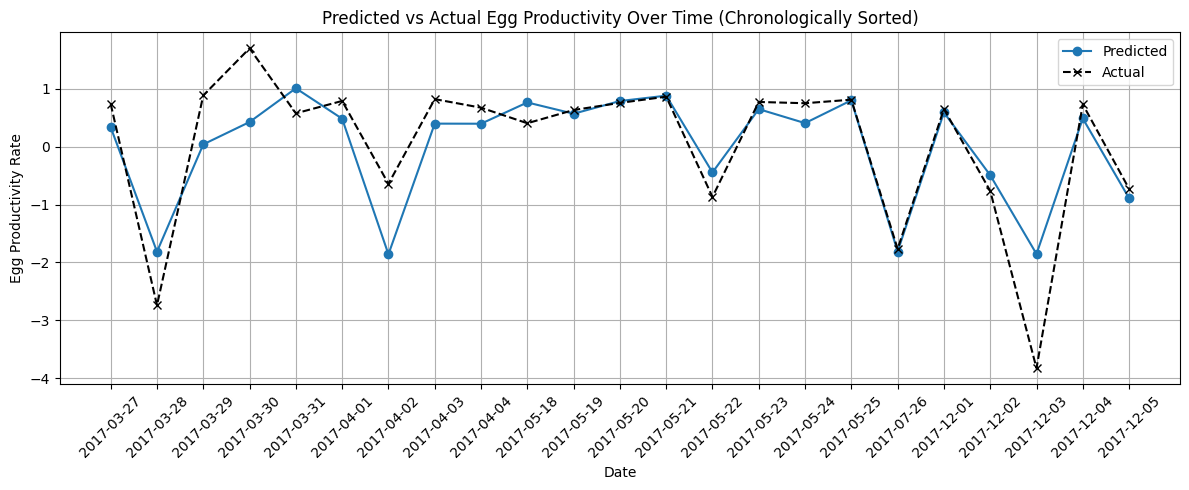

In [85]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

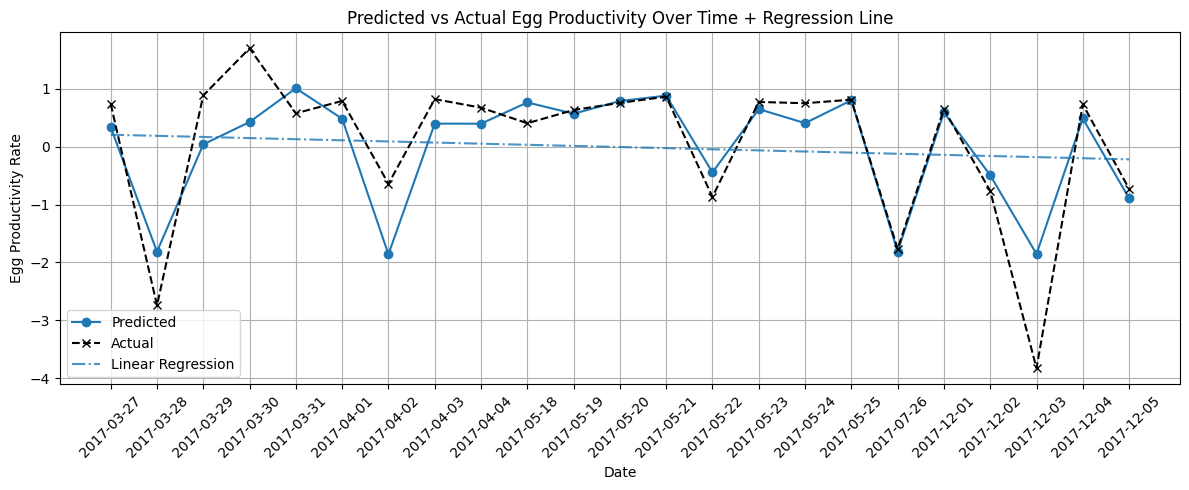

In [86]:
from sklearn.linear_model import LinearRegression

n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date").reset_index(drop=True)

X = np.arange(len(df_plot)).reshape(-1, 1)  # index as time proxy
y = df_plot["predicted"].values
reg = LinearRegression().fit(X, y)
reg_line = reg.predict(X)

# Add regression line to the plot
plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.plot(df_plot["date"], reg_line, label="Linear Regression", linestyle="-.", color="tab:blue", alpha=0.8)

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time + Regression Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

15:55:53 - cmdstanpy - INFO - Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing


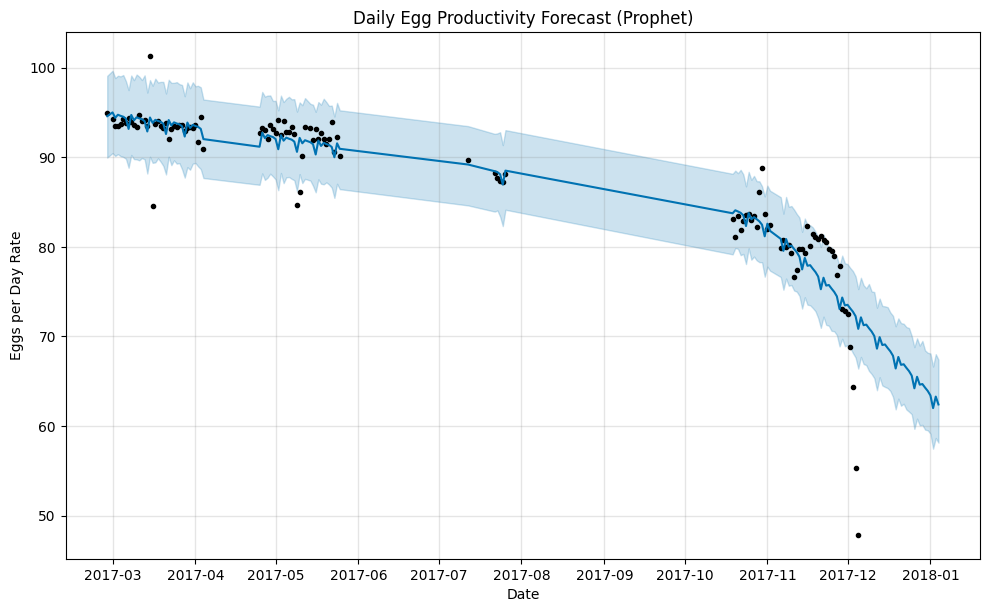

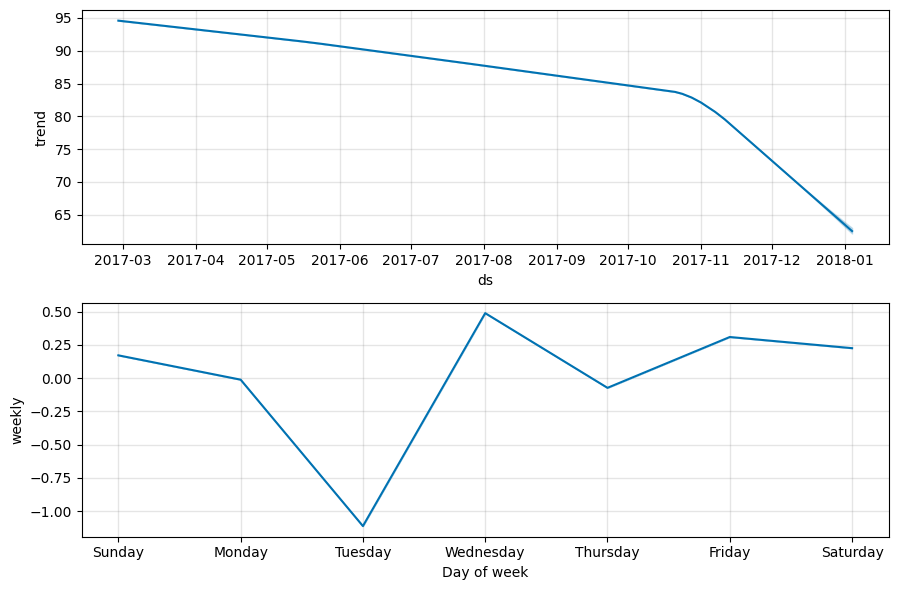

In [87]:
from prophet import Prophet

eggs_per_day_df['ds'] = pd.to_datetime(eggs_per_day_df['date'])
eggs_per_day_df['y'] = eggs_per_day_df['productivity rate']
ts = eggs_per_day_df[['ds','y']].sort_values('ds').reset_index(drop=True)

# 2. Fit Prophet on the real series
m = Prophet(daily_seasonality=False, weekly_seasonality=True)
m.fit(ts)

# 3. Make a future DataFrame (e.g. next 30 days)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# 4. Plot the forecast
fig1 = m.plot(forecast)
plt.title("Daily Egg Productivity Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Eggs per Day Rate")
plt.show()

# 5. (Optional) View trend & weekly seasonality
fig2 = m.plot_components(forecast)
plt.show()

Use now globalAttention

In [88]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)
        
        self.att_pool = GlobalAttention(gate_nn=torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        ))
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_ga_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_ga_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0874 | Val Loss: 0.6784 | RMSE: 0.8237 | MAE: 0.7388
Epoch 1 | Train Loss: 1.0800 | Val Loss: 0.6679 | RMSE: 0.8173 | MAE: 0.7334
Epoch 2 | Train Loss: 1.0555 | Val Loss: 0.6347 | RMSE: 0.7967 | MAE: 0.7158
Epoch 3 | Train Loss: 0.9837 | Val Loss: 0.5240 | RMSE: 0.7239 | MAE: 0.6631
Epoch 4 | Train Loss: 0.8488 | Val Loss: 0.4011 | RMSE: 0.6333 | MAE: 0.5814
Epoch 5 | Train Loss: 0.6675 | Val Loss: 0.2470 | RMSE: 0.4969 | MAE: 0.4527
Epoch 6 | Train Loss: 0.5197 | Val Loss: 0.1837 | RMSE: 0.4286 | MAE: 0.3483
Epoch 7 | Train Loss: 0.4129 | Val Loss: 0.1738 | RMSE: 0.4169 | MAE: 0.3156
Epoch 8 | Train Loss: 0.3908 | Val Loss: 0.1932 | RMSE: 0.4396 | MAE: 0.3211
Epoch 9 | Train Loss: 0.3625 | Val Loss: 0.1841 | RMSE: 0.4291 | MAE: 0.3007
Epoch 10 | Train Loss: 0.3513 | Val Loss: 0.2217 | RMSE: 0.4708 | MAE: 0.3486
Epoch 11 | Train Loss: 0.3559 | Val Loss: 0.1900 | RMSE: 0.4359 | MAE: 0.2977
Epoch 12 | Train Loss: 0.3525 | Val Loss: 0.1973 | RMSE: 0.4442 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.1426 | Val Loss: 0.4415 | RMSE: 0.6645 | MAE: 0.6248
Epoch 1 | Train Loss: 1.1279 | Val Loss: 0.4425 | RMSE: 0.6652 | MAE: 0.6269
Epoch 2 | Train Loss: 1.0999 | Val Loss: 0.4350 | RMSE: 0.6596 | MAE: 0.6222
Epoch 3 | Train Loss: 1.0446 | Val Loss: 0.4053 | RMSE: 0.6366 | MAE: 0.5996
Epoch 4 | Train Loss: 0.9500 | Val Loss: 0.3042 | RMSE: 0.5515 | MAE: 0.5119
Epoch 5 | Train Loss: 0.8059 | Val Loss: 0.1977 | RMSE: 0.4446 | MAE: 0.3970
Epoch 6 | Train Loss: 0.6233 | Val Loss: 0.1246 | RMSE: 0.3530 | MAE: 0.2969
Epoch 7 | Train Loss: 0.4865 | Val Loss: 0.0861 | RMSE: 0.2935 | MAE: 0.2302
Epoch 8 | Train Loss: 0.4141 | Val Loss: 0.1123 | RMSE: 0.3352 | MAE: 0.2372
Epoch 9 | Train Loss: 0.3906 | Val Loss: 0.1244 | RMSE: 0.3527 | MAE: 0.2318
Epoch 10 | Train Loss: 0.3824 | Val Loss: 0.1149 | RMSE: 0.3390 | MAE: 0.2279
Epoch 11 | Train Loss: 0.3854 | Val Loss: 0.1433 | RMSE: 0.3785 | MAE: 0.2500
Epoch 12 | Train Loss: 0.3752 | Val Loss: 0.1068 | RMSE: 0.3268 | MAE: 0.2

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.8361 | Val Loss: 1.6831 | RMSE: 1.2973 | MAE: 0.9435
Epoch 1 | Train Loss: 0.8248 | Val Loss: 1.6788 | RMSE: 1.2957 | MAE: 0.9358
Epoch 2 | Train Loss: 0.8029 | Val Loss: 1.6580 | RMSE: 1.2876 | MAE: 0.9201
Epoch 3 | Train Loss: 0.7675 | Val Loss: 1.5883 | RMSE: 1.2603 | MAE: 0.8911
Epoch 4 | Train Loss: 0.6864 | Val Loss: 1.4581 | RMSE: 1.2075 | MAE: 0.8271
Epoch 5 | Train Loss: 0.5688 | Val Loss: 1.3084 | RMSE: 1.1439 | MAE: 0.7240
Epoch 6 | Train Loss: 0.4449 | Val Loss: 1.1714 | RMSE: 1.0823 | MAE: 0.6098
Epoch 7 | Train Loss: 0.3538 | Val Loss: 1.0192 | RMSE: 1.0096 | MAE: 0.5335
Epoch 8 | Train Loss: 0.2995 | Val Loss: 0.9138 | RMSE: 0.9560 | MAE: 0.4897
Epoch 9 | Train Loss: 0.2699 | Val Loss: 0.8604 | RMSE: 0.9276 | MAE: 0.4682
Epoch 10 | Train Loss: 0.2407 | Val Loss: 0.7708 | RMSE: 0.8780 | MAE: 0.5080
Epoch 11 | Train Loss: 0.2540 | Val Loss: 0.8203 | RMSE: 0.9057 | MAE: 0.4581
Epoch 12 | Train Loss: 0.2436 | Val Loss: 0.7701 | RMSE: 0.8775 | MAE: 0.4

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.1133 | Val Loss: 0.5491 | RMSE: 0.7410 | MAE: 0.6650
Epoch 1 | Train Loss: 1.1038 | Val Loss: 0.5369 | RMSE: 0.7327 | MAE: 0.6586
Epoch 2 | Train Loss: 1.0761 | Val Loss: 0.5089 | RMSE: 0.7134 | MAE: 0.6415
Epoch 3 | Train Loss: 1.0191 | Val Loss: 0.4466 | RMSE: 0.6683 | MAE: 0.5993
Epoch 4 | Train Loss: 0.9005 | Val Loss: 0.3583 | RMSE: 0.5986 | MAE: 0.5225
Epoch 5 | Train Loss: 0.7600 | Val Loss: 0.2602 | RMSE: 0.5101 | MAE: 0.4257
Epoch 6 | Train Loss: 0.6012 | Val Loss: 0.2001 | RMSE: 0.4473 | MAE: 0.3588
Epoch 7 | Train Loss: 0.4645 | Val Loss: 0.1970 | RMSE: 0.4439 | MAE: 0.3130
Epoch 8 | Train Loss: 0.4092 | Val Loss: 0.2277 | RMSE: 0.4772 | MAE: 0.3531
Epoch 9 | Train Loss: 0.3700 | Val Loss: 0.2412 | RMSE: 0.4911 | MAE: 0.3725
Epoch 10 | Train Loss: 0.3662 | Val Loss: 0.2259 | RMSE: 0.4752 | MAE: 0.3563
Epoch 11 | Train Loss: 0.3455 | Val Loss: 0.2462 | RMSE: 0.4962 | MAE: 0.3765
Epoch 12 | Train Loss: 0.3394 | Val Loss: 0.2497 | RMSE: 0.4997 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.8363 | Val Loss: 1.6703 | RMSE: 1.2924 | MAE: 1.0232
Epoch 1 | Train Loss: 0.8303 | Val Loss: 1.6573 | RMSE: 1.2874 | MAE: 1.0218
Epoch 2 | Train Loss: 0.8144 | Val Loss: 1.6227 | RMSE: 1.2739 | MAE: 1.0131
Epoch 3 | Train Loss: 0.7758 | Val Loss: 1.5309 | RMSE: 1.2373 | MAE: 0.9692
Epoch 4 | Train Loss: 0.7001 | Val Loss: 1.3782 | RMSE: 1.1740 | MAE: 0.9022
Epoch 5 | Train Loss: 0.5885 | Val Loss: 1.1616 | RMSE: 1.0778 | MAE: 0.7990
Epoch 6 | Train Loss: 0.4616 | Val Loss: 0.9155 | RMSE: 0.9568 | MAE: 0.6643
Epoch 7 | Train Loss: 0.3633 | Val Loss: 0.7246 | RMSE: 0.8512 | MAE: 0.5504
Epoch 8 | Train Loss: 0.3085 | Val Loss: 0.6375 | RMSE: 0.7984 | MAE: 0.4779
Epoch 9 | Train Loss: 0.2951 | Val Loss: 0.5557 | RMSE: 0.7455 | MAE: 0.4775
Epoch 10 | Train Loss: 0.2914 | Val Loss: 0.5874 | RMSE: 0.7664 | MAE: 0.4436
Epoch 11 | Train Loss: 0.2805 | Val Loss: 0.5972 | RMSE: 0.7728 | MAE: 0.4337
Epoch 12 | Train Loss: 0.2837 | Val Loss: 0.5485 | RMSE: 0.7406 | MAE: 0.4

### 7) Evaluate

In [89]:
import pandas as pd

target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity rate"})
eggs_per_day_df['productivity rate'] = eggs_per_day_df['productivity rate'].str.replace(',', '.').astype(float)
eggs_per_day_df.head(5)

,date,productivity rate
0,2017-02-27,94.960274
1,2017-03-01,94.260145
2,2017-04-25,92.655367
3,2017-07-12,89.730444
4,2017-07-22,88.271474


In [90]:
mean_eggs = eggs_per_day_df["productivity rate"].mean()
std_eggs = eggs_per_day_df["productivity rate"].std()

print(f"Mean productivity rate: {mean_eggs:.2f}")
print(f"Standard deviation of productivity rate: {std_eggs:.2f}")

Mean productivity rate: 87.16
Standard deviation of productivity rate: 8.34


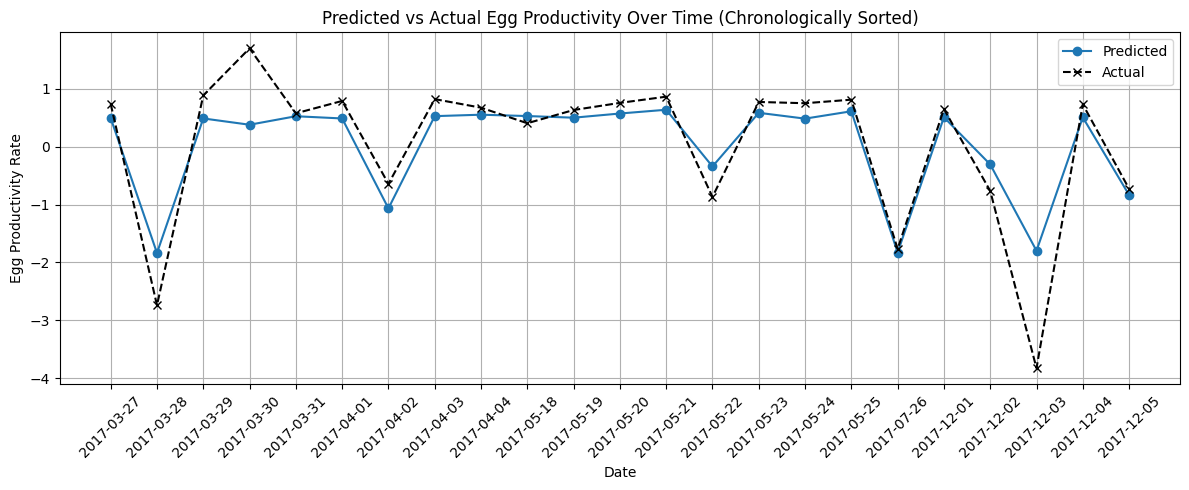

In [91]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

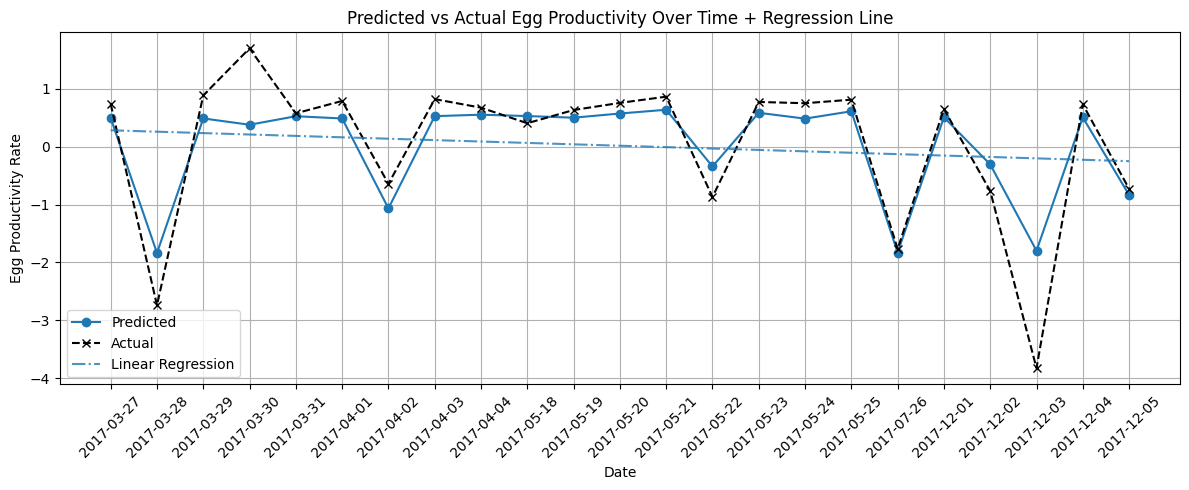

In [92]:
from sklearn.linear_model import LinearRegression

n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date").reset_index(drop=True)

X = np.arange(len(df_plot)).reshape(-1, 1)  # index as time proxy
y = df_plot["predicted"].values
reg = LinearRegression().fit(X, y)
reg_line = reg.predict(X)

# Add regression line to the plot
plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.plot(df_plot["date"], reg_line, label="Linear Regression", linestyle="-.", color="tab:blue", alpha=0.8)

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time + Regression Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing


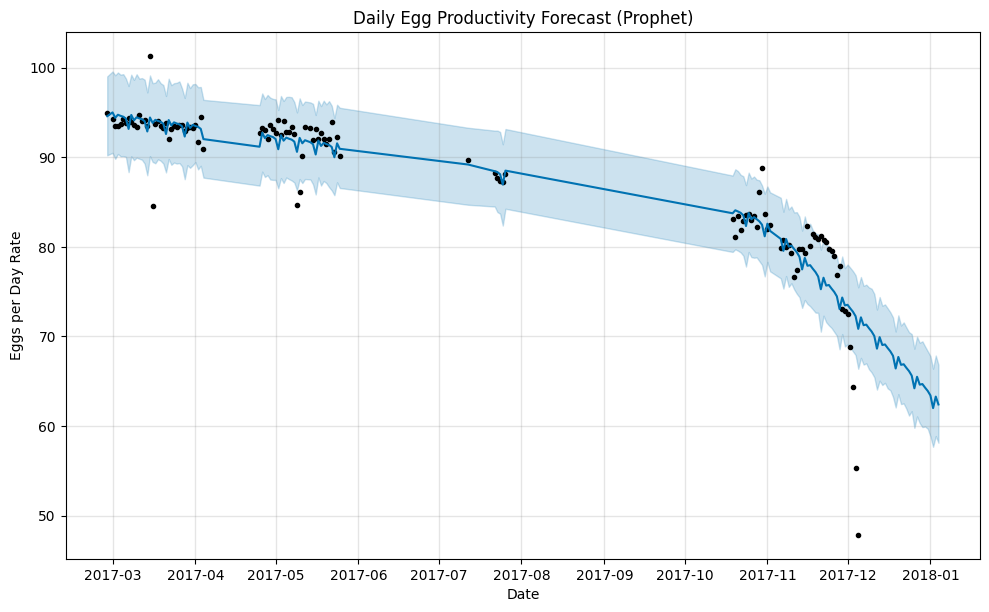

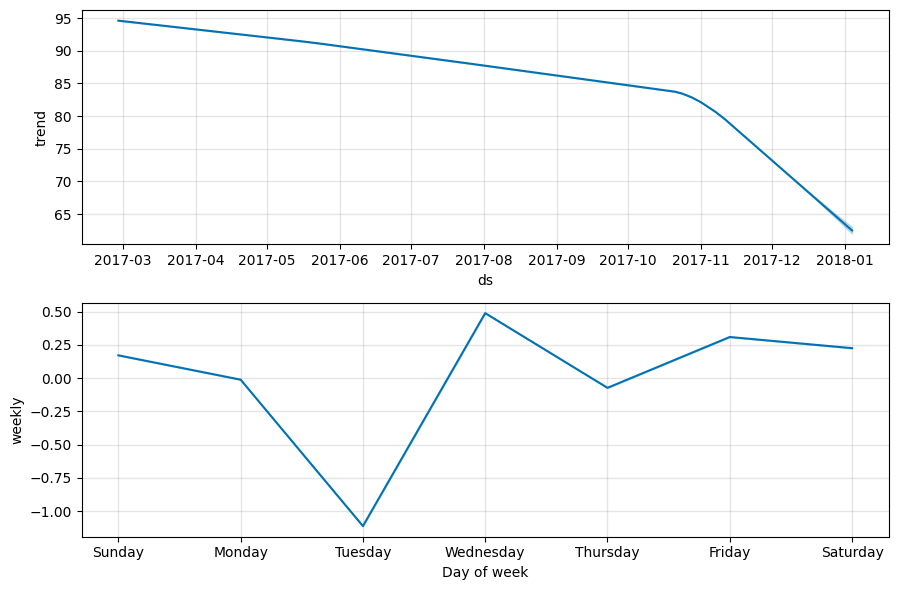

In [94]:
from prophet import Prophet

eggs_per_day_df['ds'] = pd.to_datetime(eggs_per_day_df['date'])
eggs_per_day_df['y'] = eggs_per_day_df['productivity rate']
ts = eggs_per_day_df[['ds','y']].sort_values('ds').reset_index(drop=True)

# 2. Fit Prophet on the real series
m = Prophet(daily_seasonality=False, weekly_seasonality=True)
m.fit(ts)

# 3. Make a future DataFrame (e.g. next 30 days)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# 4. Plot the forecast
fig1 = m.plot(forecast)
plt.title("Daily Egg Productivity Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Eggs per Day Rate")
plt.show()

# 5. (Optional) View trend & weekly seasonality
fig2 = m.plot_components(forecast)
plt.show()

## Model Evaluation: Egg Productivity Prediction

### Baseline Statistics
- **Mean productivity rate:** 87.16  
- **Standard deviation:** 8.34  

---

### Model 1: Global Mean Pooling
- **Average RMSE:** 0.5359 ± 0.2512  
- **Average MAE:** 0.3239 ± 0.1025  
- Highest error among all models — suggests mean pooling may dilute critical node-level information.

---

### Model 2: Global Max Pooling
- **Average RMSE:** 0.5221 ± 0.1723  
- **Average MAE:** 0.3760 ± 0.0689  
- Slight improvement in RMSE over mean pooling — max pooling may capture dominant node signals, though MAE increased.

---

### Model 3: Global Attention Pooling
- **Average RMSE:** 0.4623 ± 0.1234  
- **Average MAE:** 0.3067 ± 0.0578  
- Best performance overall — attention mechanism helps identify and weight important nodes, improving both accuracy and consistency.

---

### Overall Insights
- Switching from **mean to attention pooling** significantly reduced prediction error.
- Attention pooling **outperformed both mean and max** in terms of RMSE and MAE.
- **Model 3’s MAE (0.3067)** is approximately **1/27th** of the standard deviation — indicating strong prediction performance relative to variability in the data.

## Graphs Insights

### Time-series visualization

- For each pooling strategy, a graph with dates on the x-axis and egg-productivity rate on the y-axis was plotted, showing both the model’s predictions and the true observed rates.

### Linear trend line

- A version of the same plot as above, but with a regression line was also shown, useful to have an overall look at the trend over time, but the data seems to not follow a proper pattern, so it is not suitable for forecasting.

### Forecasting model

- To overcome this and provide an idea of future predictions in terms of eggs per day rate, the library Prophet will be used. 

- Prophet is a procedure for forecasting time series data where non-linear trends are fit with yearly, weekly, and daily seasonality, that works well with time series that have strong seasonal effects and several seasons of historical data.

### Interpretation

- The data shows that from March through early December, productivity hovers around 90–95%, while after December it’s forecast to decline into the 60–70% range by end the 30-day time span to forecast, with growing uncertainty.
- It can also be seen that productivity systematically varies by day of the week, with Tuesdays that tend to be about –1% below the baseline trend and Wednesdays and Fridays that see a +0.5% bump above trend.
